# [TESS Data Workshop](http://www.stsci.edu/institute/conference/tess): Box Least Squares (BLS) Tutorial

*Based on work by [Daniel Foreman-Mackey](https://twitter.com/exoplaneteer), [Christina Hedges](TheChedgehog), [Zé Vinícius](https://twitter.com/mircaze),  and collaborators.*

In this tutorial, we will demonstrate the usage patterns for the brand new `astropy.stats.bls` package to identify transiting planet candidates in TESS light curves. If you are already familiar with AstroPy and the BLS algorithm, you may prefer to head straight to the [AstroPy BLS documentation](http://docs.astropy.org/en/latest/stats/bls.html). If Python or BLS are new to you, this tutorial will provide you with step-by-step instructions to get started.

***

## Table of Contents

* [1. Getting Started](#1.-Getting-Started)
* [2. What is Box Least Squares?](#2.-What-is-Box-Least-Squares?)
* [3. Example 1: Finding TESS Planet Candidates using AstroPy BLS](#3.-Example-1:-Finding-TESS-Planet-Candidates-using-AstroPy-BLS)
   * [3.1. Obtaining and plotting a light curve](#3.1.-Obtaining-and-plotting-a-light-curve)
   * [3.2. Running BLS using AstroPy](#3.2.-Running-BLS-using-AstroPy)
   * [3.3. Inspecting a planet candidate](#3.3.-Inspecting-a-planet-candidate)
   * [3.4. Finding additional planet candidates using masking](#3.4.-Finding-additional-planet-candidates-using-masking)
* [4. Example 2: Finding TESS Planet Candidates using Lightkurve](#4.-Example-2:-Finding-TESS-planet-candidates-using-Lightkurve)
  * [4.1. What is Lightkurve?](#4.1.-What-is-Lightkurve?)
  * [4.2. Loading and plotting a light curve](#4.2.-Loading-and-plotting-a-light-curve)
  * [4.3. Running AstroPy BLS via Lightkurve](#4.3.-Running-AstroPy-BLS-via-Lightkurve)
  * [4.4. Interactive BLS using Lightkurve](#4.4.-Interactive-BLS-using-Lightkurve)
* [5. Common Caveats](#5.-Common-Caveats)
  * [5.1. Avoid NaNs in your light curves](#5.1.-Avoid-NaNs-in-your-light-curves)
  * [5.2. Remove long-term trends](#5.2.-Remove-long-term-trends)
* [6. Alternatives to BLS](#6.-Alternatives-to-BLS)

***

## 1. Getting Started

To run this tutorial, you will need to install the recent `astropy` version 3.1 or higher (which is compatible with Python 3 only). BLS was only [recently added](https://github.com/astropy/astropy/pull/7391) to AstroPy and is not available in older versions.

You can verify your version of `astropy` as follows:

In [1]:
import astropy
astropy.__version__

'3.1'

We will also be using the `numpy`, `matplotlib`, and `lightkurve` packages below.

***

## 2. What is Box Least Squares?

The Box Least Squares (BLS) algorithm ([Kovacs et al. 2002](http://adsabs.harvard.edu/abs/2002A%26A...391..369K))  is a standard method used to detect transiting exoplanets and eclipsing binaries in time series datasets. We won't go into the details here, but the basic idea is that the transit is modeled as a top hat and, under the assumption of known independent Gaussian uncertainties, this leads to several simplifications that make evaluating the model likelihood computationally efficient.

The transit periodogram computes the log likelihood of the "box" fit (maximized over transit depth, duration, and phase) for a list of periods. Peaks in the periodogram generally indicate transiting planets or other unmodeled noise.
Methods for determining the false alarm rates with these methods is an active area of research so we won't go into that here, but users should always be cautious with their interpretation of the results from a method like this.

***

## 3. Example 1: Finding TESS Planet Candidates using AstroPy BLS

### 3.1. Obtaining and plotting a light curve

We will start our search by downloading a TESS light curve file from the [TESS Data Alerts Page at MAST](https://archive.stsci.edu/prepds/tess-data-alerts/), but this could be any light curve file produced by the TESS Pipeline:

In [2]:
url = "https://archive.stsci.edu/hlsps/tess-data-alerts/hlsp_tess-data-alerts_tess_phot_00307210830-s02_tess_v1_lc.fits"

This is a FITS file containing a table with multiple data columns.  We'll use the `PDCSAP_FLUX` column, which provides the pipeline-processed light curve and has already been corrected for long term trends and instrument systematics.

Let's plot the data to see what it looks like!

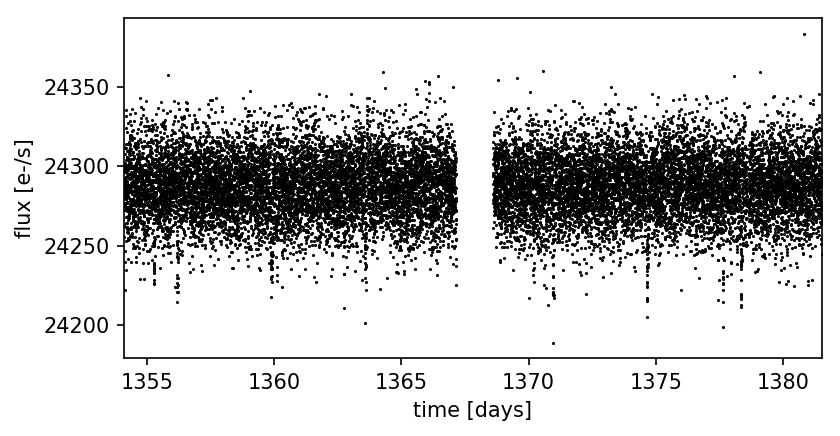

In [3]:
# Plotting parameters
%matplotlib inline
%config IPython.matplotlib.backend = "retina"
from matplotlib import rcParams
rcParams["figure.dpi"] = 150
import matplotlib.pyplot as plt

# Package imports
import numpy as np
from astropy.io import fits

# Download and read the light curve file
with fits.open(url) as hdus:
    data = hdus[1].data
    time = data["TIME"]
    flux = data["PDCSAP_FLUX"]
    quality = data["QUALITY"]

# Mask out any data with imperfect quality
m = (quality == 0)
time = time[m]
flux = flux[m]

# Plot the light curve
fig, ax = plt.subplots(1, 1, sharex=True, figsize=(6, 3))
ax.plot(time, flux, ".k", ms=1)
ax.set_xlim([time.min(), time.max()])
ax.set_xlabel("time [days]")
ax.set_ylabel("flux [e-/s]");

### 3.2. Running BLS using AstroPy

Now, to find a transiting planet in this light curve, we use the `astropy.stats.BoxLeastSquares` class.
The class was designed to follow the conventions of `astropy.stats.LombScargle` so this might seem familiar to those of you who are familiar with that.

First, the user must select a set of transit durations to test (in the same units as the time variable above). Then, a search can be run using the following commands (see the [docstrings](http://docs.astropy.org/en/latest/stats/bls.html) for all the options):

In [4]:
durations = np.linspace(0.05, 0.2, 10)

from astropy.stats import BoxLeastSquares
bls = BoxLeastSquares(time, flux)
results = bls.autopower(durations, frequency_factor=5.0)

The `results` object is a dictionary with the following keys:

In [5]:
list(results.keys())

['objective',
 'period',
 'power',
 'depth',
 'depth_err',
 'duration',
 'transit_time',
 'depth_snr',
 'log_likelihood']

The meaning of these parameters is defined on the relevant [AstroPy documentation page](http://docs.astropy.org/en/latest/api/astropy.stats.BoxLeastSquaresResults.html#astropy.stats.BoxLeastSquaresResults). Let's take a look at their values:

In [6]:
print(results)

          depth: array([ 0.5885875 ,  0.58336147,  0.58810647, ..., 21.9858118 ,
       20.7983098 , 25.02455764])
      depth_err: array([0.01477821, 0.01477827, 0.01477822, ..., 0.11808344, 0.11808344,
       0.11808344])
      depth_snr: array([ 39.82807188,  39.47427663,  39.79548114, ..., 186.18878396,
       176.13231863, 211.92267079])
       duration: array([0.2 , 0.2 , 0.2 , ..., 0.05, 0.05, 0.05])
 log_likelihood: array([ 1601.2236773 ,  1573.59623735,  1598.78044567, ...,
       17401.53314234, 15572.50885695, 22544.22546847])
      objective: 'likelihood'
         period: array([ 0.4       ,  0.40005327,  0.40010656, ..., 13.55098846,
       13.61239642, 13.67436346])
          power: array([ 1601.2236773 ,  1573.59623735,  1598.78044567, ...,
       17401.53314234, 15572.50885695, 22544.22546847])
   transit_time: array([0.25882313, 0.07349829, 0.29323197, ..., 9.69497665, 3.49418122,
       7.22184038])


The output from this method has several useful columns, but the most useful ones are probably `period` and `power`.
Using these, we can plot the periodogram:

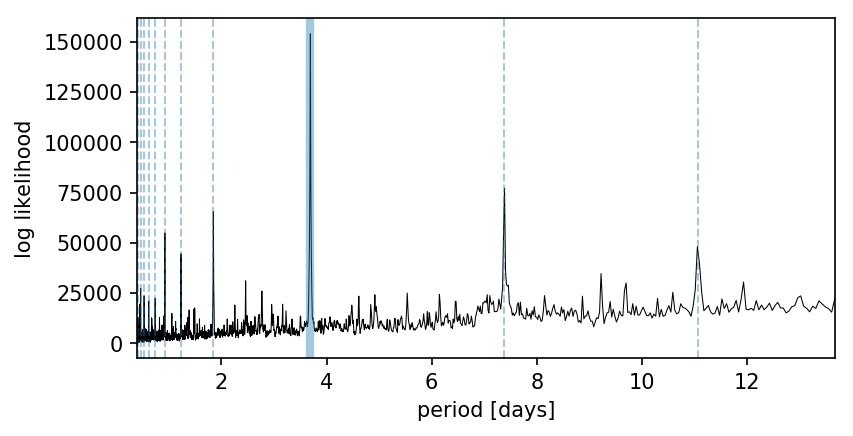

In [7]:
# Find the period of the peak
period = results.period[np.argmax(results.power)]

# Plot the periodogram
rcParams["figure.dpi"] = 150
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.plot(results.period, results.power, "k", lw=0.5)
ax.set_xlim(results.period.min(), results.period.max())
ax.set_xlabel("period [days]")
ax.set_ylabel("log likelihood")

# Highlight the harmonics of the peak period
ax.axvline(period, alpha=0.4, lw=4)
for n in range(2, 10):
    ax.axvline(n*period, alpha=0.4, lw=1, linestyle="dashed")
    ax.axvline(period / n, alpha=0.4, lw=1, linestyle="dashed")

The structure that you can see in this periodogram is pretty typical for a system with transiting planets.
The peak period is highlighted with a thick blue line and the integer harmonics of this period are indicated with dashed blue lines.

### 3.3. Inspecting a planet candidate

We can compare the BLS model agains the data using the `BoxLeastSquares.model` method:

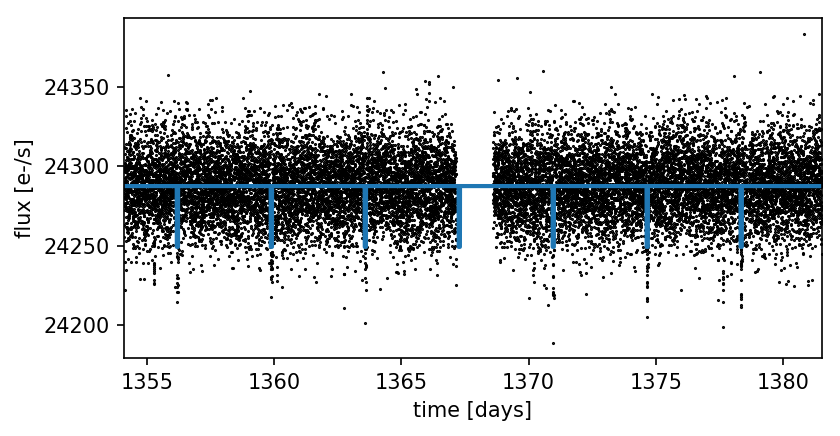

In [8]:
# Extract the parameters of the best-fit model
index = np.argmax(results.power)
period = results.period[index]
t0 = results.transit_time[index]
duration = results.duration[index]

# Plot the light curve and best-fit model
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.plot(time, flux, ".k", ms=1)
x = np.linspace(time.min(), time.max(), 3*len(time))
model_flux = bls.model(x, period, duration, t0)
ax.plot(x, model_flux, lw=2)
ax.set_xlim(time.min(), time.max())
ax.set_xlabel("time [days]")
ax.set_ylabel("flux [e-/s]");

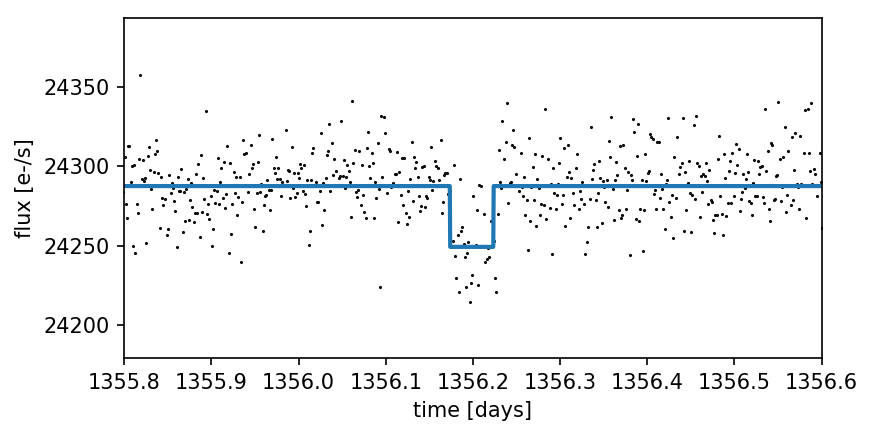

In [9]:
# Zoom in on the first transit
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.plot(time, flux, ".k", ms=1)
x = np.linspace(time.min(), time.max(), 3*len(time))
model_flux = bls.model(x, period, duration, t0)
ax.plot(x, model_flux, lw=2)
ax.set_xlim(1355.8, 1356.6)
ax.set_xlabel("time [days]")
ax.set_ylabel("flux [e-/s]");

We can also fold the data using the period found:

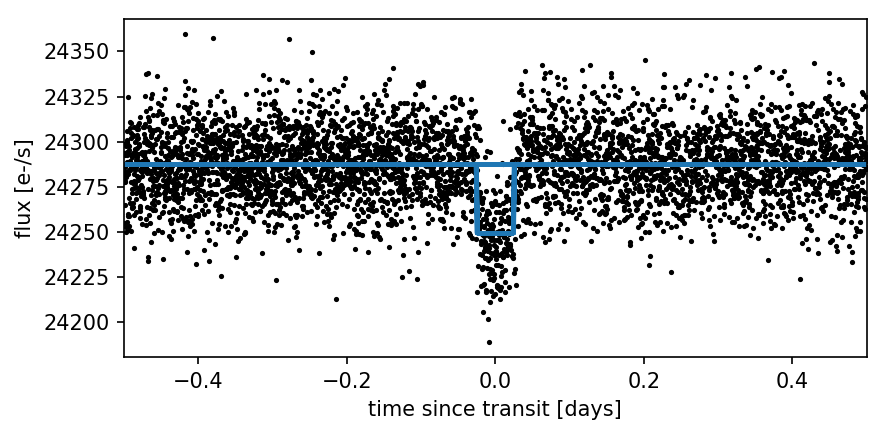

In [10]:
# Plot the folded data points within 0.5 days of the transit time
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
phase = (time - t0 + 0.5*period) % period - 0.5*period
m = np.abs(phase) < 0.5
ax.plot(phase[m], flux[m], ".k", ms=3)

# Over-plot the best fit model
x = np.linspace(-0.5, 0.5, 1000)
model_flux = bls.model(phase + t0, period, duration, t0)
ax.plot(phase, model_flux, lw=2)
ax.set_xlim(-0.5, 0.5)
ax.set_xlabel("time since transit [days]")
ax.set_ylabel("flux [e-/s]")
plt.tight_layout()

The `compute_stats()` method can be used to compute statistics about our model fit. These will be useful for vetting our transit candidate:

In [11]:
stats = bls.compute_stats(period, duration, t0)
stats

{'transit_times': array([1356.19882313, 1359.89056904, 1363.58231495, 1367.27406087,
        1370.96580678, 1374.65755269, 1378.34929861]),
 'per_transit_count': array([31, 36, 36,  0, 36, 36, 36]),
 'per_transit_log_likelihood': array([16911.47986656, 29025.31807184, 20232.29249417,     0.        ,
        27039.14123466, 34647.95487194, 26232.62311201]),
 'depth': (38.21724005539727, 0.06924281048083866),
 'depth_phased': (0.1301856091049558, 0.059706662138308164),
 'depth_half': (16.33341317027589, 0.04552189150432553),
 'depth_odd': (36.1289879600954, 0.08514384836681328),
 'depth_even': (42.248726739388076, 0.11808522007128255),
 'harmonic_amplitude': 0.8016076829533165,
 'harmonic_delta_log_likelihood': -149359.7572322837}

*Note: We have created this dictionary by passing the period, duration and transit midpoint that we would like to evaluate the statistics at.*

These statistics are documented in the docstring for the `compute_stats()` method, which is [available online](http://docs.astropy.org/en/latest/api/astropy.stats.BoxLeastSquares.html#astropy.stats.BoxLeastSquares.compute_stats) or via Python.  Many of these statistics are based on the [VARTOOLS package](https://www.astro.princeton.edu/~jhartman/vartools.html) ([Hartman & Bakos 2016](https://arxiv.org/abs/1605.06811)).

The `stats` dictionary gives us access to the best fit depth of the period, duration and transit midpoint we passed.

In [12]:
stats['depth']

(38.21724005539727, 0.06924281048083866)

This tuple contains the depth value, and the error on the depth value.

We also have acces to the depth for **odd** numbered transits, and the depth of **even** numbered tranits. 

In [13]:
odd_depth, odd_depth_err = stats['depth_odd']
print('Odd Depth = {:.1f} +/- {:.1f}'.format(odd_depth, odd_depth_err))

Odd Depth = 36.1 +/- 0.1


In [14]:
even_depth, even_depth_err = stats['depth_even']
print('Even Depth = {:.1f} +/- {:.1f}'.format(even_depth, even_depth_err))

Even Depth = 42.2 +/- 0.1


The `harmonic_delta_log_likelihood` is the difference in log likelihood between a sinusoidal model and the transit model. If `harmonic_delta_log_likelihood` is greater than zero, the sinusoidal model is preferred.

In [15]:
stats['harmonic_delta_log_likelihood']

-149359.7572322837

Finally, `transit_times` is a convenient way to access the times in the data when a transit is thought to have occured:

In [16]:
stats['transit_times']

array([1356.19882313, 1359.89056904, 1363.58231495, 1367.27406087,
       1370.96580678, 1374.65755269, 1378.34929861])

### 3.4. Finding additional planet candidates using masking

A common way to find more planets in a light curve where the highest signal-to-noise transit has been detected is to remove the in-transit data points and then run the algorithm again.

We can do this using the `BoxLeastSquares.transit_mask` method:

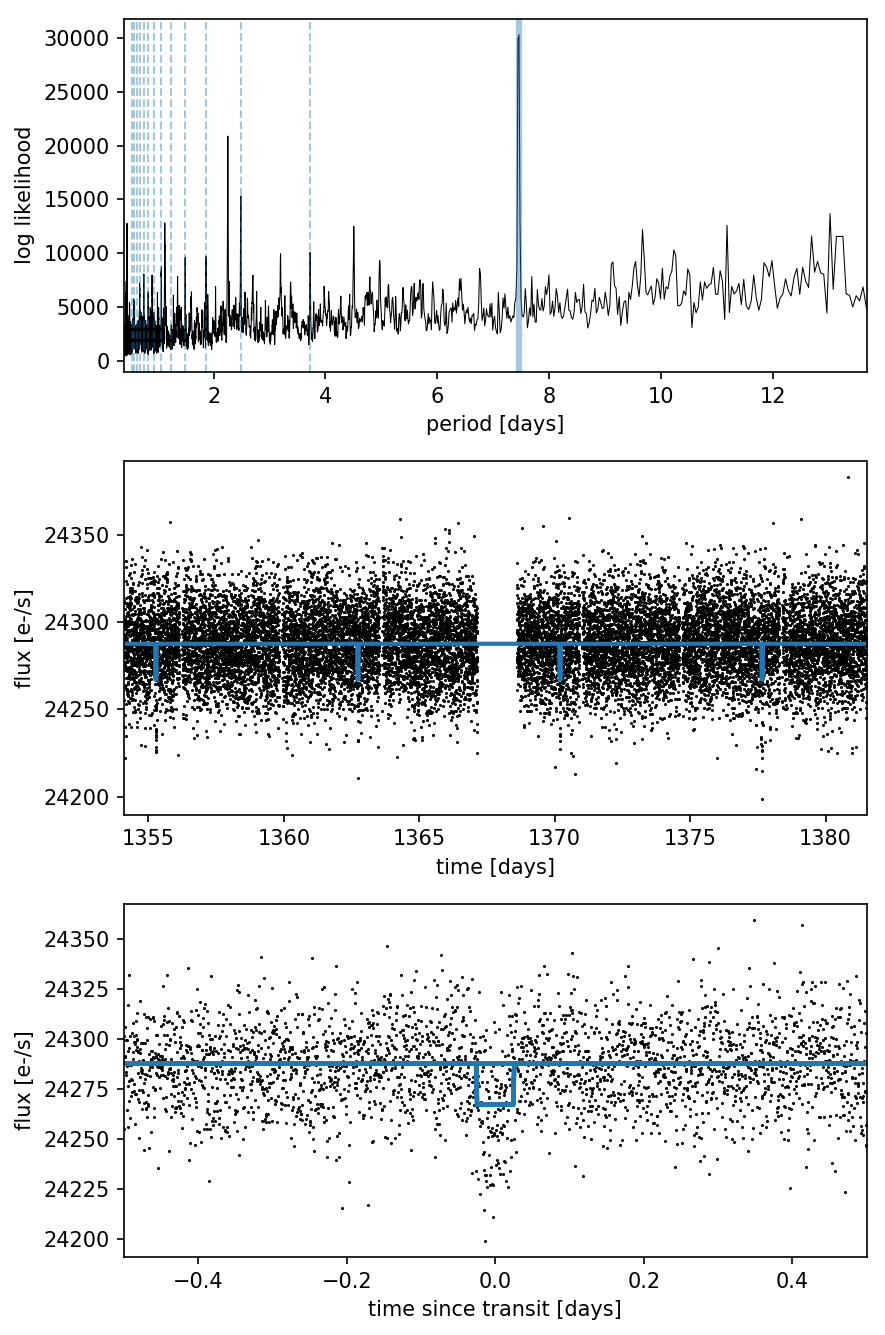

In [17]:
# Find the in-transit points using a longer duration as a buffer to avoid ingress and egress
in_transit = bls.transit_mask(time, period, 2*duration, t0)

# Re-run the algorithm, and plot the results
bls2 = BoxLeastSquares(time[~in_transit], flux[~in_transit])
results2 = bls2.autopower(durations, frequency_factor=5.0)

# Extract the parameters of the best-fit model
index = np.argmax(results2.power)
period2 = results2.period[index]
t02 = results2.transit_time[index]
duration2 = results2.duration[index]

# Plot the periodogram
fig, axes = plt.subplots(3, 1, figsize=(6, 9))
ax = axes[0]
ax.plot(results2.period, results2.power, "k", lw=0.5)
ax.set_xlim(results2.period.min(), results2.period.max())
ax.set_xlabel("period [days]")
ax.set_ylabel("log likelihood")

# Highlight the harmonics of the peak period

ax.axvline(period2, alpha=0.4, lw=3)
for n in range(2, 15):
    ax.axvline(n*period2, alpha=0.4, lw=1, linestyle="dashed")
    ax.axvline(period2 / n, alpha=0.4, lw=1, linestyle="dashed")

# Plot the light curve
ax = axes[1]
ax.plot(time[~in_transit], flux[~in_transit], ".k", ms=1)
x = np.linspace(time.min(), time.max(), 3*len(time))
f = bls2.model(x, period2, duration2, t02)
ax.plot(x, f, lw=2)
ax.set_xlim(time.min(), time.max())
ax.set_xlabel("time [days]")
ax.set_ylabel("flux [e-/s]");

# Plot the best fit model
ax = axes[2]
phase = (time[~in_transit] - t02 + 0.5*period2) % period2 - 0.5*period2
m = np.abs(phase) < 0.5
ax.plot(phase[m], flux[~in_transit][m], ".k", ms=1)
x = np.linspace(-0.5, 0.5, 1000)
f = bls2.model(phase + t02, period2, duration2, t02)
ax.plot(phase, f, lw=2)
ax.set_xlim(-0.5, 0.5)
ax.set_xlabel("time since transit [days]")
ax.set_ylabel("flux [e-/s]")
plt.tight_layout()

As before, we can also compute some descriptive stats for this candidate.

In [18]:
bls2.compute_stats(period2, duration2, t02)

{'transit_times': array([1355.27882313, 1362.73867128, 1370.19851943, 1377.65836759]),
 'per_transit_count': array([36, 36, 36, 36]),
 'per_transit_log_likelihood': array([9185.47499808, 5869.30582471, 6881.35663261, 8361.61115157]),
 'depth': (20.513460556077916, 0.08367071662938974),
 'depth_phased': (-5.583518255571107, 0.08367347080152492),
 'depth_half': (7.4423199605735135, 0.05940561836856359),
 'depth_odd': (21.134974770488043, 0.11808993719077032),
 'depth_even': (19.89194634166779, 0.11808993719077032),
 'harmonic_amplitude': 0.12425601668850486,
 'harmonic_delta_log_likelihood': -29993.965135775972}

Now let's do it one more time to find the third planet.

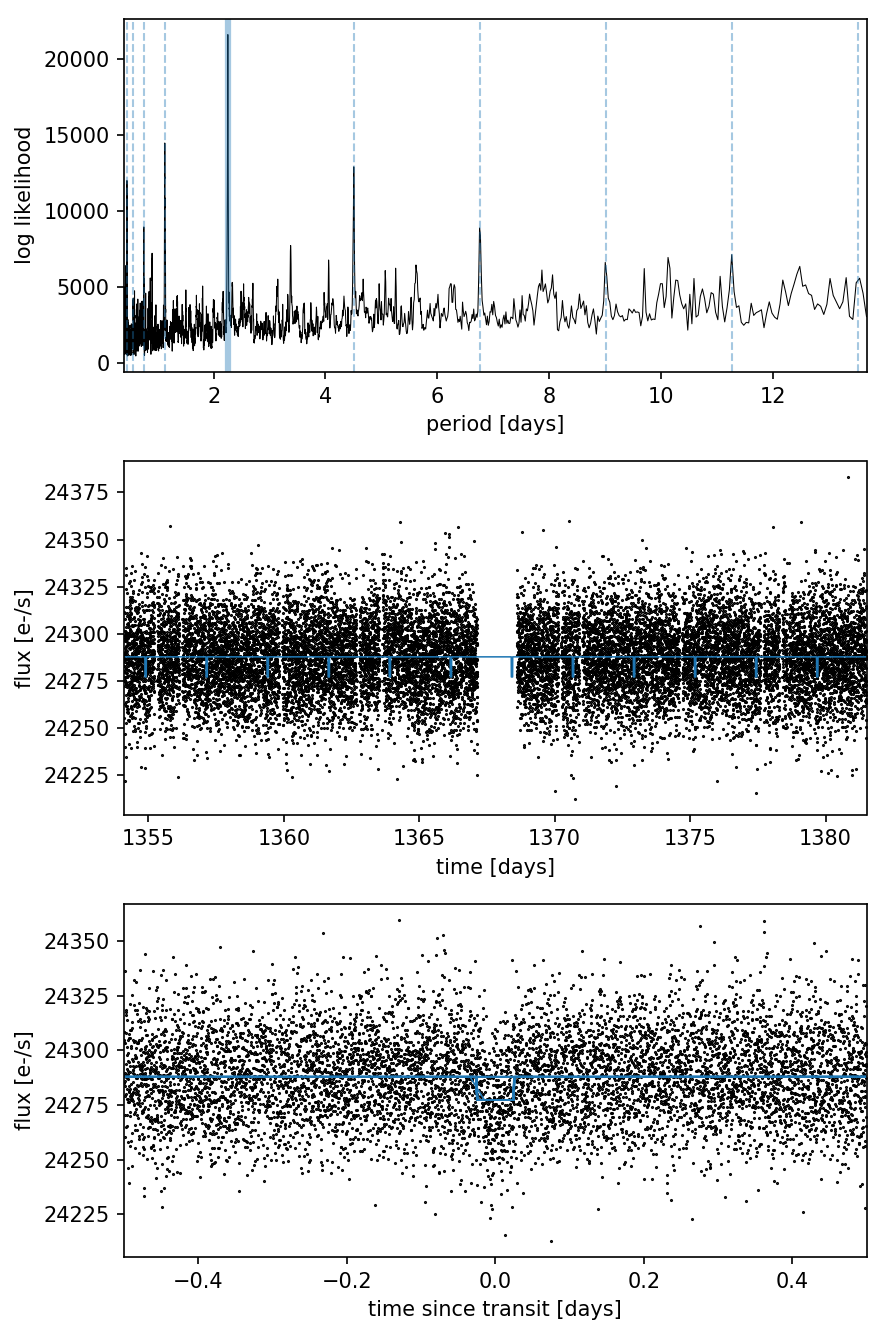

In [19]:
in_transit2 = in_transit | bls2.transit_mask(time, period2, 2*duration2, t02)

# Re-run the algorithm, and plot the results
bls3 = BoxLeastSquares(time[~in_transit2], flux[~in_transit2])
results3 = bls3.autopower(durations, frequency_factor=5.0)

# Extract the parameters of the best-fit model
index = np.argmax(results3.power)
period3 = results3.period[index]
t03 = results3.transit_time[index]
duration3 = results3.duration[index]

# Plot the periodogram
fig, axes = plt.subplots(3, 1, figsize=(6, 9))
ax = axes[0]
ax.plot(results3.period, results3.power, "k", lw=0.5)
ax.set_xlim(results3.period.min(), results3.period.max())
ax.set_xlabel("period [days]")
ax.set_ylabel("log likelihood")

# Highlight the harmonics of the peak period
ax.axvline(period3, alpha=0.4, lw=3)
for n in range(2, 15):
    ax.axvline(n*period3, alpha=0.4, lw=1, linestyle="dashed")
    ax.axvline(period3 / n, alpha=0.4, lw=1, linestyle="dashed")

# Plot the light curve
ax = axes[1]
ax.plot(time[~in_transit2], flux[~in_transit2], ".k", ms=1)
x = np.linspace(time.min(), time.max(), 3*len(time))
model_flux = bls3.model(x, period3, duration3, t03)
ax.plot(x, model_flux, lw=0.75)
ax.set_xlim(time.min(), time.max())
ax.set_xlabel("time [days]")
ax.set_ylabel("flux [e-/s]")

# Plot the best fit model
ax = axes[2]
phase3 = (time[~in_transit2] - t03 + 0.5*period3) % period3 - 0.5*period3
m = np.abs(phase3) < 0.5
ax.plot(phase3[m], flux[~in_transit2][m], ".k", ms=1)
x = np.linspace(-0.5, 0.5, 1000)
f = bls3.model(phase3 + t03, period3, duration3, t03)
ax.plot(phase3, f, lw=0.75)
ax.set_xlim(-0.5, 0.5)
ax.set_xlabel("time since transit [days]")
ax.set_ylabel("flux [e-/s]")
plt.tight_layout()

***

## 4. Example 2: Finding TESS planet candidates using Lightkurve

### 4.1. What is Lightkurve?

Lightkurve ([https://docs.lightkurve.org](https://docs.lightkurve.org)) is the Kepler/K2 GO Office Python package to work with NASA Kepler, K2, and TESS data. There is another workshop for you to learn the ins and outs of Lightkurve.

Lightkurve does not provide a separate implementation of BLS because the AstroPy implementation is great!
Instead, Lightkurve provides easy access to AstroPy BLS using a series of convenience methods which allow you to run BLS in just a few lines of code.

### 4.2. Loading and plotting a light curve

Let's start with loading the light curve file from MAST and creating a `LightCurve` object.  We don't need to know the URL, we can use Lightkurve to search via `astroquery`:

In [20]:
import lightkurve as lk
lc = lk.search_lightcurvefile("TIC 307210830").download().PDCSAP_FLUX

This returns an object of type `TessLightCurve`.

In [21]:
lc

TessLightCurve(TICID: 307210830)

`LightCurve` objects offer a range of convenience method, e.g. we can plot our light curve using:

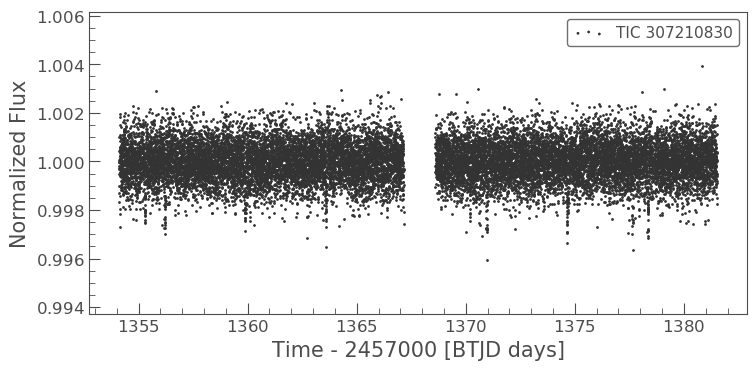

In [22]:
lc.scatter();

### 4.3. Running AstroPy BLS via Lightkurve

A light curve object has a convenience method called `to_periodogram(method="bls")`.  This method takes exactly the same keyword arguments that we previously passed to `BoxLeastSquares.autopower()`.

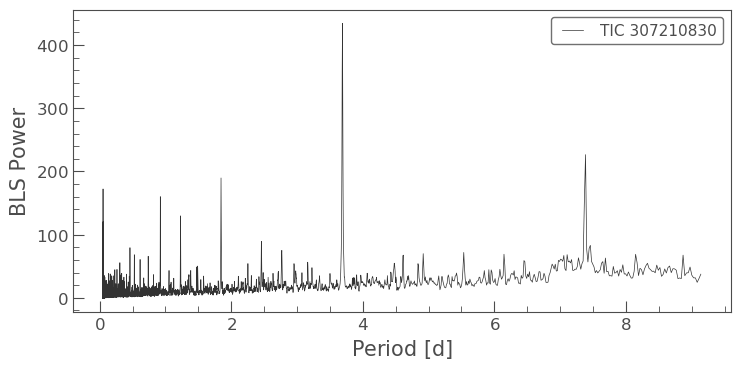

In [23]:
pg = lc.to_periodogram("bls", frequency_factor=5, duration=0.05)
pg.plot();

The period and transit_time of the strongest peak are available via convenient properties, for example:

In [24]:
pg.period_at_max_power

<Quantity 3.69169188 d>

In [25]:
pg.transit_time_at_max_power

1.3479027319364896

We can inspect the folded light curve using LightKurve's `fold()` method, and average the points and look closer at the shape of the transit using the `bin()` method:

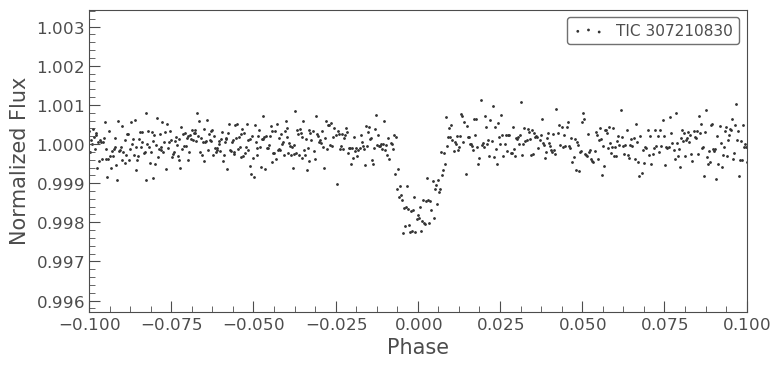

In [26]:
lc.fold(pg.period_at_max_power.value, pg.transit_time_at_max_power).bin(5).scatter()
plt.xlim([-0.1, 0.1]);

### 4.4. Interactive BLS using Lightkurve

A new (somewhat experimental) feature of Lightkurve provides an interactive widget to run BLS.  Because the browser widget needs to talk to the Python code, this feature will only work if you are running a local Python notebook server (i.e. this will not work on a cloud-hosted notebook).

In [27]:
lc.normalize().interact_bls('http://localhost:8888')

***

# 5. Common Caveats

## 5.1. Avoid NaNs in your light curves

A single missing or `NaN` value in your time, flux, or flux_err arrays will trigger `BoxLeastSquares` to return `-inf` as the power for all periods.  Make sure to remove all invalid cadences before passing it on to BLS!


In [28]:
# Create a synthetic light curve with one cadence where the flux is NaN
time = np.linspace(1, 10, 1000)
flux = np.ones(1000)
flux[5] = np.nan

# Attempt to run BLS and look at the result ... all inf's!
results = BoxLeastSquares(time, flux).autopower(duration=0.05)
results.power

/home/gb/bin/anaconda/lib/python3.6/site-packages/numpy/lib/function_base.py:3250: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


array([-inf, -inf, -inf, ..., -inf, -inf, -inf])

## 5.2. Remove long-term trends

Many targets have long term trends, e.g. due to star spots and stellar rotation.  These trends add noise to a BLS periodogram. It is important to remove them from a light curve before running BLS. (*Caution: trend removal often ends up removing some of the transit signal as well!*)

For example, Kepler-10 is known to host a planet on a 0.8-day period. The example below shows the BLS periodogram of Kepler-10 with and without long-term trend removal.  We remove the long term trend using Lightkurve's `flatten()` method and compare the difference.

First, let's plot the light curves with and without long-term trend filtering:

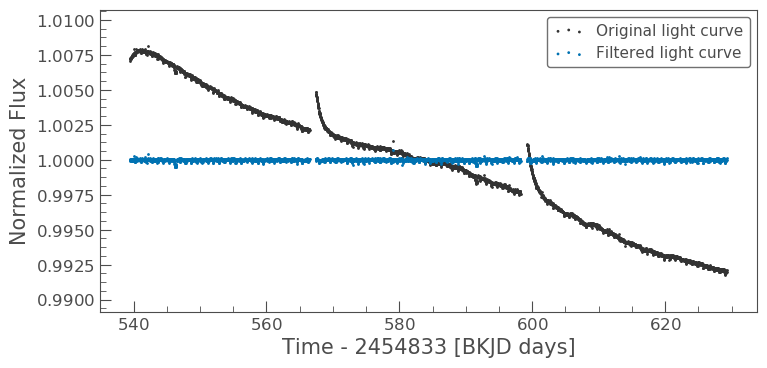

In [29]:
# Plot the original light curve
lc = lk.search_lightcurvefile("Kepler-10", quarter=6).download().SAP_FLUX.remove_nans()
ax = lc.scatter(label="Original light curve")

# Plot the filtered light curve
lc_flat = lc.flatten()
lc_flat.scatter(ax=ax, label="Filtered light curve");

Here is the periodogram of the original light curve:

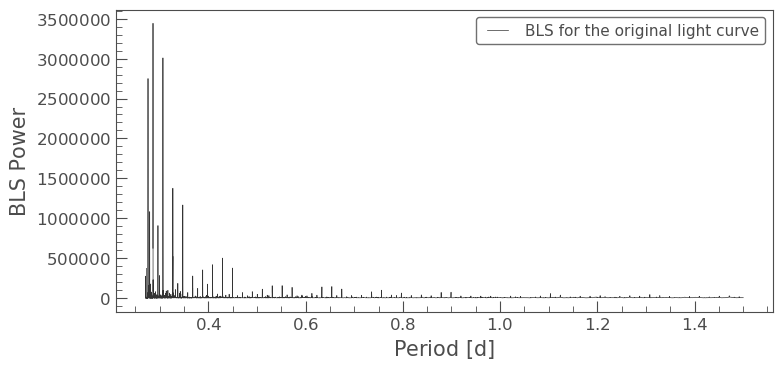

In [30]:
lc.to_periodogram("bls", maximum_period=1.5).plot(label="BLS for the original light curve");

It does not show the signal of Kepler-10b (0.8 days)!

Here is the periodogram of the filtered light curve:

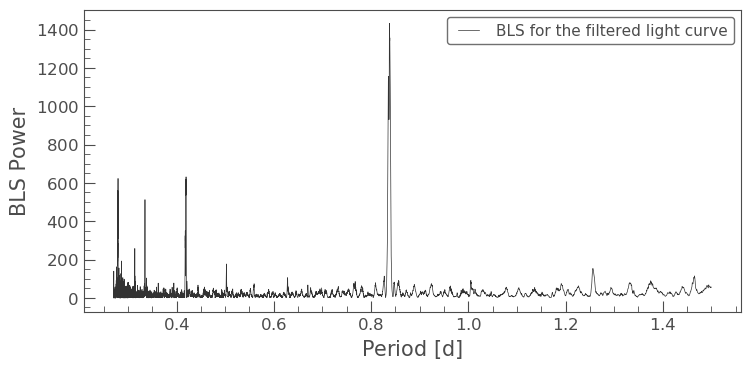

In [31]:
lc_flat.to_periodogram("bls", maximum_period=1.5).plot(label="BLS for the filtered light curve");

Only the filtered periodogram shows the signal of Kepler-10b!

***

# 6. Alternatives to BLS

BLS is by no means the only method to identify planet candidates in time series data, although it is one of the easiest to use thanks to its inclusion in AstroPy. Here is a non-exhaustive list of alternative planet-finding strategies:

* Wavelet-based matched filter (see Chapter 9 in the [Kepler Data Processing Handbook](https://archive.stsci.edu/kepler/manuals/KSCI-19081-002-KDPH.pdf)).
* Simultaneously fitting for systematics and transit signals (e.g. [Foreman-Mackey, Montet, Hogg, et al. 2015].(https://arxiv.org/abs/1502.04715))
* The new [Transit Least Squares (TLS)](https://github.com/hippke/tls) method.

***

# Exercises

A system with one or two transiting planets often reveals additional planets upon closer inspection.  Using this knowledge, let's look for brand new planet candidates in TESS data!

* **Exercise 1**: Select a known planet candidate from the [TESS Data Alerts page at MAST](https://archive.stsci.edu/prepds/tess-data-alerts/).  Can you recover the reported candidate from the light curve using BLS yourself?
* **Exercise 2**: Create a folded light curve and compute the BLS statistics of the known candidate. Does it resemble a true planet?
* **Exercise 3**: Using transit masking explained above, can you find signs of additional, unknown transit signal candidates in addition to the known candidate?